# Color Modeling for JWST GC White Paper

In [1]:
import numpy as np
import mysg # Tom Robitaille's YSO grid tool
from astropy.table import Table
from astropy import units as u, constants
import pylab as pl
import requests

from icemodels import absorbed_spectrum, absorbed_spectrum_Gaussians, convsum, fluxes_in_filters, load_molecule, atmo_model, molecule_data
del molecule_data['h2o_b'] # don't need double water

In [2]:
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC, G21_MWAvg
from dust_extinction.parameter_averages import CCM89

In [3]:
from astropy.modeling.models import BlackBody
from astropy.visualization import simple_norm
import matplotlib
import matplotlib.colors

In [5]:
label_map = {'ch3oh': 'CH$_3$OH',
             'co2': 'CO$_2$',
             'ch4': 'CH$_4$',
             'co': 'CO',
             'h2o': 'H$_2$O',
             'nh3': 'NH$_3$',
            }

In [6]:
from astroquery.svo_fps import SvoFps
from astropy import table
filter_data_nircam = SvoFps.get_filter_list('JWST', instrument="NIRCam")
filter_data_miri = SvoFps.get_filter_list('JWST', instrument="MIRI")
filter_data_jwst = table.vstack([filter_data_nircam, filter_data_miri])
filter_data_spitzer_irac = SvoFps.get_filter_list('Spitzer', instrument='IRAC')
filter_data_spitzer_mips = SvoFps.get_filter_list('Spitzer', instrument='MIPS')
filter_data_spitzer = table.vstack([filter_data_spitzer_mips, filter_data_spitzer_irac])


for filter_data in (filter_data_jwst, filter_data_spitzer):
    filter_data.add_index('filterID')
    flxd = filter_data['filterID'] # TODO: might need to change this to only select the filters we're using below
    filter_wavelengths = [filter_data.loc[filterid]['WavelengthCen'] for filterid in flxd]
    filter_widths = [filter_data.loc[filterid]['WidthEff'] for filterid in flxd]
    filter_wlmin = [filter_data.loc[filterid]['WavelengthMin'] for filterid in flxd]
    filter_wlmax = [filter_data.loc[filterid]['WavelengthMax'] for filterid in flxd]

filter_data = filter_data_jwst

In [7]:
distance = 8.5*u.kpc
av = 30
distance_modulus = 5 * np.log10(distance / (10*u.pc))

In [8]:
xarr = np.linspace(1, 5.1, 15000)*u.um

In [9]:
phx4000 = atmo_model(4000)

In [10]:
nh3_consts = load_molecule('nh3')

In [11]:
co2_consts = load_molecule('co2')

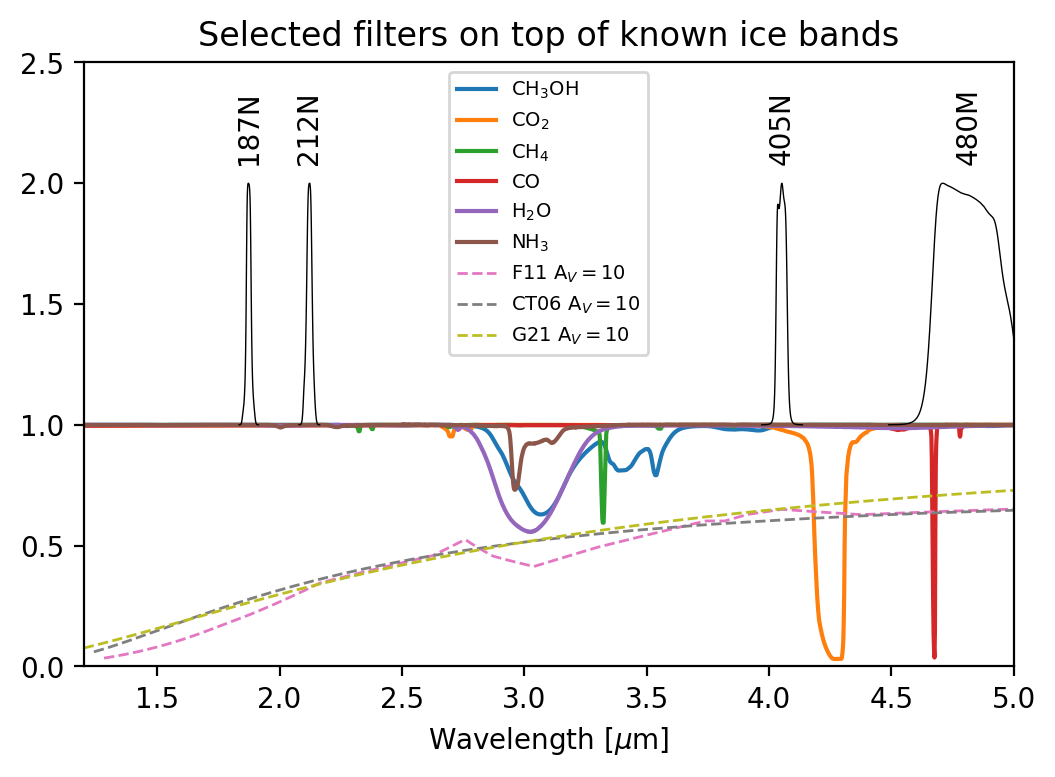

In [12]:
pl.figure(dpi=200)
# pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
#           phx4000['fnu'], color='k', linestyle=':', zorder=20,
#           linewidth=0.5)#, label="Phoenix T=4000 K")

xarr = u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral())
for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum(1e18*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.plot(xarr,
              spec / phx4000['fnu'],
              label=f"{label_map[molecule]}")
    
for ext, extname in zip((F11_MWGC(), CT06_MWGC(), G21_MWAvg()),
                        ('F11', 'CT06', 'G21'),
                       ):
    slc = ((xarr > (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).min()) &
           (xarr < (u.Quantity(ext.x_range, u.um**-1).to(xarr.unit, u.spectral())).max()))
    ext_ = ext.extinguish(xarr[slc], Av=10)
    pl.plot(xarr[slc], ext_, label=f'{extname} A$_V=10$', linestyle='--', linewidth=1)
    #pl.title("Opacity-based models")

#GTO1182 = ['F115W', 'F200W', 'F356W', 'F444W']
#GO2221 = ['F182M', 'F187N', 'F212N', 'F405N', 'F410M', 'F466N', 'F2550W']
#toplot = ['F300M', 'F210M', 'F182M', 'F410M', 'F466N', 'F150W', 'F335M', 'F480M']
toplot = ['F187N', 'F212N', 'F405N', 'F480M']
for row in filter_data:
    fname = row['filterID'].split('F')[-1]
    color = 'k'
    if 'F'+fname in toplot:
        
        pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
                2.1, fname, rotation=90, 
                horizontalalignment='center',
                color=color
               )
        trans = SvoFps.get_transmission_data(row['filterID'])
        pl.plot(trans['Wavelength'].quantity.to(u.um),
                trans['Transmission'].value/trans['Transmission'].value.max() + 1,
                linewidth=0.5, color=color)
    #if row['filterID'].endswith('M') and row['WavelengthEff'] > 25000:
    #    pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
    #            0.1, row['filterID'][-5:], rotation=90,
    #            color='orange')

pl.legend(loc='best', fontsize=7)#bbox_to_anchor=[1.0, 1.0])
pl.ylim(0, 2.5)
pl.xlim(1.2, 5)
pl.xlabel("Wavelength [$\\mu$m]");
pl.title("Selected filters on top of known ice bands");

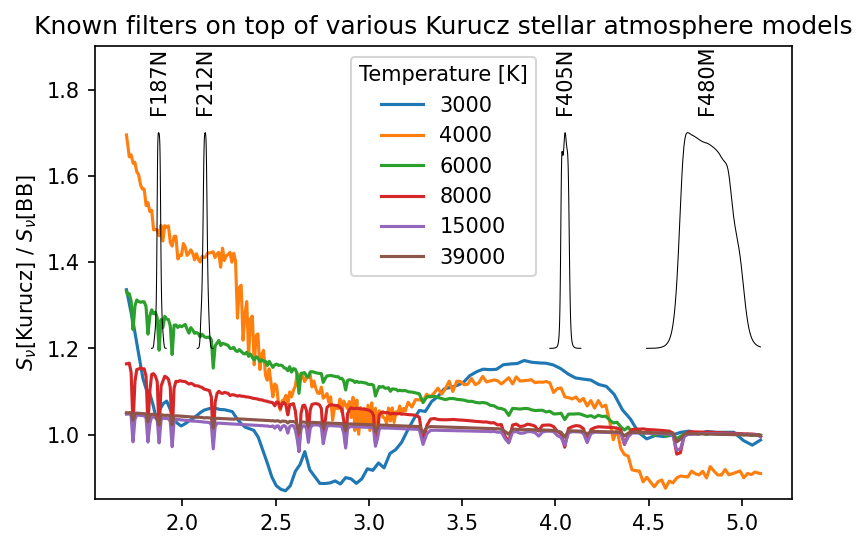

In [27]:
pl.figure(dpi=150)
for tem in (3000, 4000, 6000, 8000, 15000,  39000):
    mod = atmo_model(tem, np.linspace(1.7, 5.1, 5000)*u.um)
    lam = mod['nu'].quantity.to(u.um, u.spectral())
    sp = (mod['fnu']/mod['fnu'].max()*lam**2).value
    sp /= sp.max()
    #L, = pl.plot(lam, sp, label=str(tem))
    
    bb = BlackBody(tem*u.K)(lam)*u.sr
    spbb = ((bb/bb.max()*lam**2).value)
    spbb /= spbb.max()
    #pl.plot(lam, spbb * sp.max(), color=L.get_color(), linewidth=0.5, linestyle='--')
    pl.plot(lam, sp / spbb, label=str(tem))
    
toplot = ['F187N', 'F212N', 'F405N', 'F480M']
for filtername in toplot:
    fname = f'JWST/NIRCam.{filtername}'
    row = filter_data.loc[fname]
    color ='k'
        
    pl.text(u.Quantity(row['WavelengthEff'], u.AA).to(u.um).value,
            1.75, fname.split(".")[-1], rotation=90, 
            horizontalalignment='center',
            color=color
           )
    trans = SvoFps.get_transmission_data(row['filterID'])
    pl.plot(trans['Wavelength'].quantity.to(u.um),
            trans['Transmission'].value/trans['Transmission'].value.max()/2 + 1.2,
            linewidth=0.5, color=color)
    
#pl.ylabel(r'$\lambda^2 S_{\nu} $')
pl.ylabel(r'$S_{\nu} $[Kurucz] / $S_{\nu}$[BB]')
#pl.ylim(0.65, 1.15)
pl.ylim(0.85, 1.9);
leg = pl.legend(loc='best')
leg.set_title("Temperature [K]")
pl.title("Known filters on top of various Kurucz stellar atmosphere models");

In [14]:
temperatures = (2000, 2500, 3000, 3500, 4000, 4500, 5000, 7000, 10000, 12000, 15000, 25000, 39000)

xarr = np.concatenate([SvoFps.get_transmission_data(f'JWST/NIRCam.{filtername}')['Wavelength'].quantity
                       for filtername in ['F187N', 'F212N', 'F405N', 'F480M']])

tmods = {temperature: atmo_model(temperature, xarr=xarr)
         for temperature in temperatures}

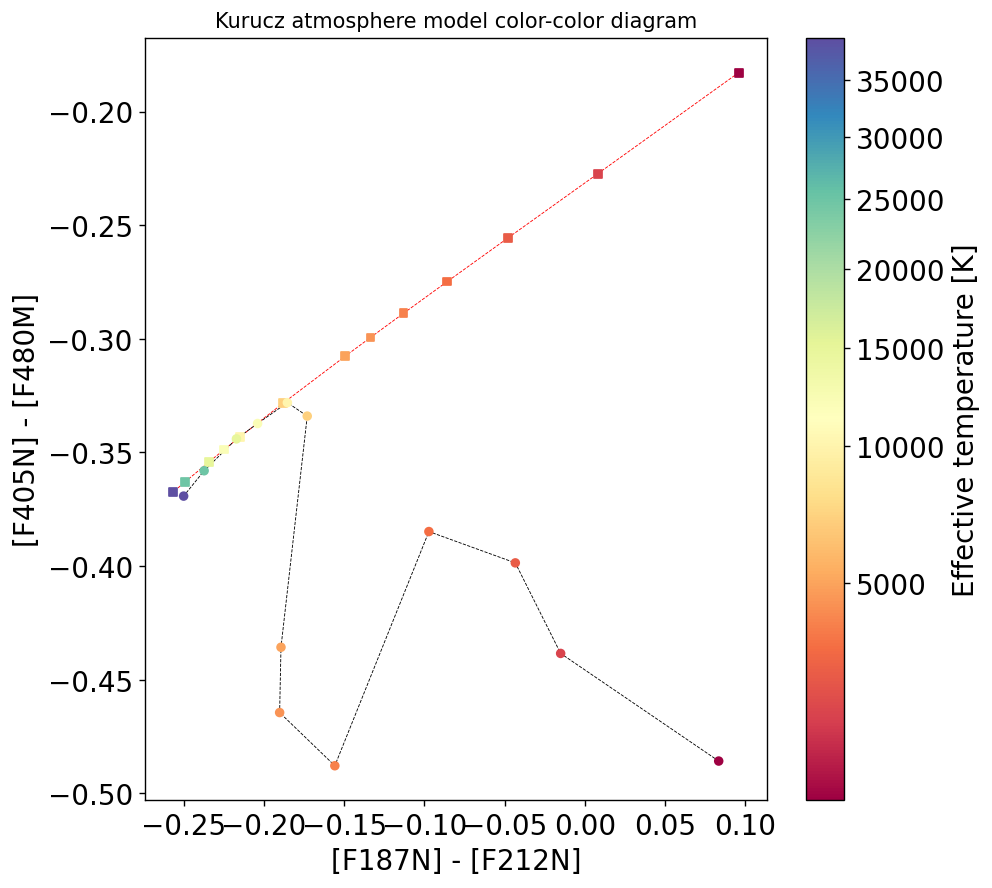

In [26]:
ccds2 = [
    (('JWST/NIRCam.F187N', 'JWST/NIRCam.F212N'),
     ('JWST/NIRCam.F405N', 'JWST/NIRCam.F480M')),
# no ice    (('JWST/NIRCam.F187N', 'JWST/NIRCam.F182M'),
# no ice     ('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N')),

]    
pl.figure(figsize=(8, 7), dpi=125)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())

temperatures = (2000, 2500, 3000, 3500, 4000, 4500, 5000, 7000, 10000, 12000, 15000, 25000, 39000)

xarr = np.concatenate([SvoFps.get_transmission_data(f'JWST/NIRCam.{filtername}')['Wavelength'].quantity
                       for filtername in ['F187N', 'F212N', 'F405N', 'F480M']])

tmods = {temperature: atmo_model(temperature, xarr=xarr)
         for temperature in temperatures}

cmap = 'Spectral'
with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(ccds2):
        ax = pl.subplot(1, 1, ii+1)
        ax.set_xlabel(f'[{cmd_x[0][-5:]}] - [{cmd_x[1][-5:]}]')
        ax.set_ylabel(f'[{cmd_y[0][-5:]}] - [{cmd_y[1][-5:]}]')

        
        xdata = []
        ydata = []
        for temperature in temperatures:
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            flxd = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
            mags_x = flxd[cmd_x[0]].to(u.ABmag).value, flxd[cmd_x[1]].to(u.ABmag).value
            mags_y = flxd[cmd_y[0]].to(u.ABmag).value, flxd[cmd_y[1]].to(u.ABmag).value
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            
        ax.plot(xdata, ydata, label='Kurucz', color='k', linewidth=0.5, linestyle='--', zorder=-9)
        sc = ax.scatter(xdata, ydata, c=temperatures, cmap=cmap, s=20, norm=simple_norm(temperatures, stretch='sqrt'))
        
        xdata = []
        ydata = []
        for tem in temperatures:
            bb = BlackBody(tem*u.K)
            flxd = fluxes_in_filters(xarr, bb(xarr)*u.sr)
            mags_x = flxd[cmd_x[0]].to(u.ABmag).value, flxd[cmd_x[1]].to(u.ABmag).value
            mags_y = flxd[cmd_y[0]].to(u.ABmag).value, flxd[cmd_y[1]].to(u.ABmag).value
            #ax.scatter(mags_x[0]-mags_x[1], mags_y[0]-mags_y[1], marker='x', s=25, color='k')
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
            
        ax.plot(xdata, ydata, label='Pure Blackbody', color='r', linewidth=0.5, linestyle='--', zorder=-10)
        sc1 = ax.scatter(xdata, ydata, c=temperatures, cmap=cmap, s=20, marker='s', norm=simple_norm(temperatures, stretch='sqrt'), zorder=-5)
        
        
        #for marker, temperature, xx, yy in zip('xos^p+hv>d<8HXD', temperatures, xdata, ydata):
        #    sc1 = ax.scatter(xx, yy, marker=marker, color='k', label=f'{temperature} K')
        #    sc1.set_facecolor('none')
        #    sc1.set_edgecolor('k')
        

    cb = pl.colorbar(mappable=sc)
    cb.set_label("Effective temperature [K]")
    #pl.legend(loc='best')#upper right', bbox_to_anchor=[1.45,1.0])
    #pl.suptitle("N(ice) = $5\\times10^{18}$ cm$^{-2}$")
pl.tight_layout()
pl.title("Kurucz atmosphere model color-color diagram");

# Compare to MIST Isochrone models

In [16]:
from astropy.table import Table
from astropy.visualization import simple_norm

In [17]:
import requests
from tqdm.notebook import tqdm
import zipfile
from bs4 import BeautifulSoup
from astropy.table import Table

def trynum(x):
    try:
        return int(x)
    except:
        try:
            return float(x)
        except:
            return x

def data_to_json(x):
    return {y.split(":")[0]: trynum(y.split(":")[1].strip()) for y in x.split("\n")}

# retrieve MIST isochrones
resp = requests.post('https://waps.cfa.harvard.edu/MIST/iso_form.php',
                     data=data_to_json("""version: 1.2
v_div_vcrit: vvcrit0.4
age_scale: log10
age_value:
age_range_low:
age_range_high:
age_range_delta:
age_list:
age_type: standard
FeH_value: 0
theory_output: basic
output_option: photometry
output: JWST
Av_value: 0"""))
resp.raise_for_status()

url = 'https://waps.cfa.harvard.edu/MIST/' + BeautifulSoup(resp.text).find('a').attrs['href']
filename = os.path.basename(url)

with requests.get(url, stream=True) as stream:
    stream.raise_for_status()
    with open(f'MIST_isochrone_package.zip', 'wb') as fh:
        for chunk in tqdm(stream.iter_content(8192)):
            fh.write(chunk)

with zipfile.ZipFile('MIST_isochrone_package.zip') as zf:
    print(zf.infolist())
    zf.extractall('isochrones/')
    fname = zf.filelist[0].filename

0it [00:00, ?it/s]

[<ZipInfo filename='MIST_iso_64baaf624dbaa.iso.cmd' compress_type=deflate filemode='-rw-r--r--' file_size=89570890 compress_size=19125166>]


In [18]:
mist = Table.read(f'isochrones/{fname}',
                  header_start=12, data_start=13, format='ascii', delimiter=' ', comment='#')
mist['410M405'] = mist['F410M']
mist['405M410'] = mist['F405N']

/tmp/ipykernel_23564/2974780136.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5]),


(-0.15, 0.1, -0.1, 0.25)

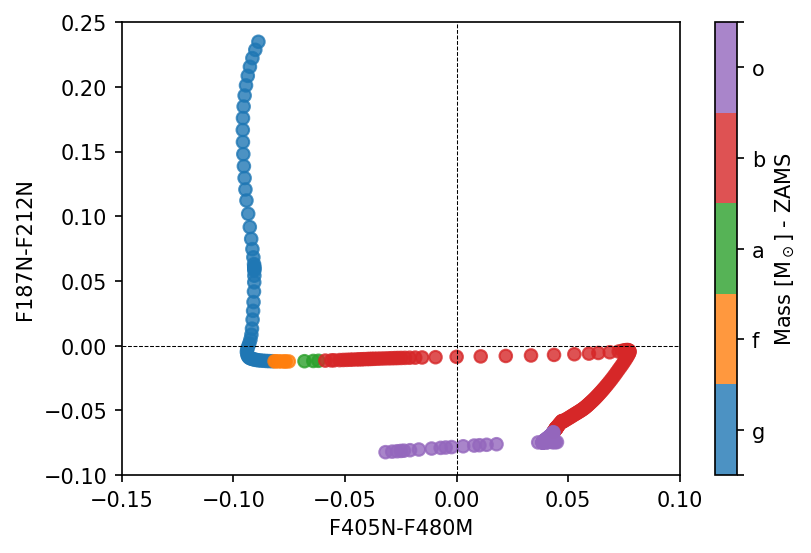

In [19]:
pl.figure(dpi=150)
ax = pl.gca()

massrange = {'o': (16, np.max(mist['initial_mass'])),
             'b': (2.1, 16),
             'a': (1.4, 2.1),
             'f': (1.04, 1.4),
             'g': (0.8, 1.04),
            }

color = np.zeros_like(mist['initial_mass'])
for ii, sptype in enumerate('gfabo'):
    thissel = (mist['initial_mass'] >= massrange[sptype][0]) & (mist['initial_mass'] < massrange[sptype][1])
    target = ii * (1./len(massrange))
    color[thissel] = target



agesel = (mist['log10_isochrone_age_yr'] == 5) & ((mist['F212N'] + distance_modulus) < 20)
sc = ax.scatter(mist['F405N'][agesel] - mist['F480M'][agesel],
           (mist['F187N']-mist['F212N'])[agesel],
           #c=mist['initial_mass'][agesel],
           #cmap='tab10',
           cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5]),
           c=color[agesel],
           #norm=simple_norm(color[agesel]),
           alpha=0.8,
          )
cb = pl.colorbar(mappable=sc)
#cb.set_ticks([0.5,1,5,10,50,250])
#cb.set_ticks([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
cb.set_ticks([0.0, 1/5 * 0.8 / 2, 3/10 * 0.8, 5/10 * 0.8, 7/10*0.8, 9/10*0.8, 0.8,])
cb.set_ticklabels(['', 'g', 'f', 'a', 'b', 'o', ''])
cb.set_label("Mass [M$_\odot$] - ZAMS")





pl.axhline(0, linestyle='--', color='k', linewidth=0.5)
pl.axvline(0, linestyle='--', color='k', linewidth=0.5)
pl.xlabel("F405N-F480M")
pl.ylabel("F187N-F212N")
pl.axis([-0.15,0.1,-0.1,0.25])

/tmp/ipykernel_23564/1681499799.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5]),
/tmp/ipykernel_23564/1681499799.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5]),


Text(0.5, 1.0, 'MIST: ZAMS and 10 Gyr')

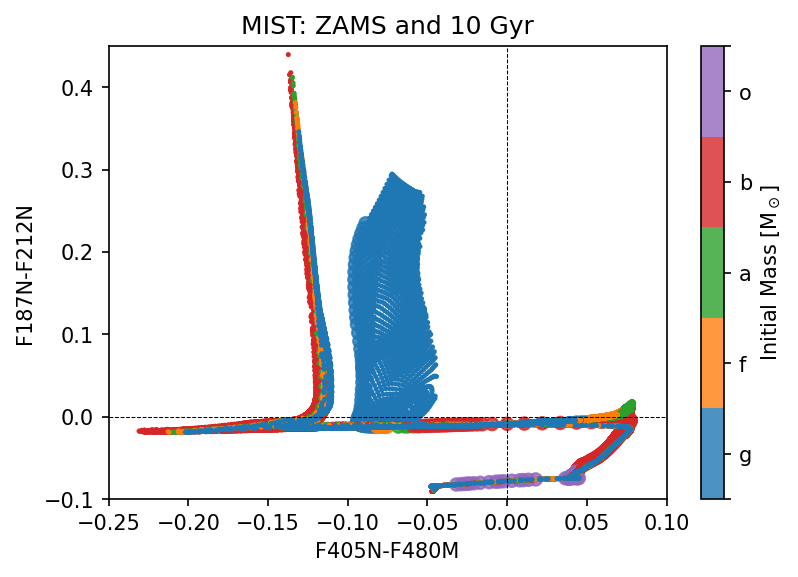

In [20]:
#pl.figure(figsize=(10,8))
pl.figure(dpi=150)
ax = pl.gca()

massrange = {'o': (16, np.max(mist['initial_mass'])),
             'b': (2.1, 16),
             'a': (1.4, 2.1),
             'f': (1.04, 1.4),
             'g': (0.8, 1.04),
            }

color = np.zeros_like(mist['initial_mass'])
for ii, sptype in enumerate('gfabo'):
    thissel = (mist['initial_mass'] >= massrange[sptype][0]) & (mist['initial_mass'] < massrange[sptype][1])
    target = ii * (1./len(massrange))
    color[thissel] = target



#cb = pl.colorbar()
#cb.set_label("Mass [M$_\odot$] - 10 Gyr")
##cb.set_ticks([0.2, 0.3, 0.5, 1])
## cb.set_ticks([0.6, 0.7, 1])
#cb.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8])
#cb.set_ticklabels(['g', 'f', 'a', 'b', 'o'])


agesel = (mist['log10_isochrone_age_yr'] == 5) & ((mist['F212N'] + distance_modulus) < 20)
sc = ax.scatter(mist['F405N'][agesel] - mist['F480M'][agesel],
           (mist['F187N']-mist['F212N'])[agesel],
           #c=mist['initial_mass'][agesel],
           #cmap='tab10',
           cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5]),
           c=color[agesel],
           #norm=simple_norm(color[agesel]),
           alpha=0.8,
          )
cb = pl.colorbar(mappable=sc)
#cb.set_ticks([0.5,1,5,10,50,250])
#cb.set_ticks([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
cb.set_ticks([0.0, 1/5 * 0.8 / 2, 3/10 * 0.8, 5/10 * 0.8, 7/10*0.8, 9/10*0.8, 0.8,])
cb.set_ticklabels(['', 'g', 'f', 'a', 'b', 'o', ''])
cb.set_label("Initial Mass [M$_\odot$]")


# include only detectable sources
agesel = ((mist['F212N'] + distance_modulus) < 20)
sc2 = ax.scatter(mist['F405N'][agesel] - mist['F480M'][agesel],
           (mist['F187N']-mist['F212N'])[agesel],
           #c=mist['initial_mass'][agesel],
           c=color[agesel],
           #norm=simple_norm(color[agesel]),
           #cmap='Set1',
           cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5]),
           s=2,
          )



pl.axhline(0, linestyle='--', color='k', linewidth=0.5)
pl.axvline(0, linestyle='--', color='k', linewidth=0.5)
pl.xlabel("F405N-F480M")
pl.ylabel("F187N-F212N")
pl.axis([-0.25,0.1,-0.1,0.45])
pl.title("MIST: ZAMS and 10 Gyr")

# Padova Isochrones

In [21]:
# Padova: doesn't have narrowband


S = requests.Session()
S.headers['User-Agent'] = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36'
rr1 = S.get('http://stev.oapd.inaf.it/cgi-bin/cmd')
rr1.raise_for_status()
padov = S.post('http://stev.oapd.inaf.it/cgi-bin/cmd_3.6',
                      data=data_to_json("""submit_form: Submit
cmd_version: 3.5
track_parsec: parsec_CAF09_v1.2S
track_colibri: parsec_CAF09_v1.2S_S_LMC_08_web
track_postagb: no
n_inTPC: 10
eta_reimers: 0.2
kind_interp: 1
kind_postagb: -1
photsys_file: tab_mag_odfnew/tab_mag_jwst_nircam_widemedium_nov22.dat
photsys_version: YBCnewVega
dust_sourceM: dpmod60alox40
dust_sourceC: AMCSIC15
kind_mag: 2
kind_dust: 0
extinction_av: 0.0
extinction_coeff: constant
extinction_curve: cardelli
kind_LPV: 3
imf_file: tab_imf/imf_kroupa_orig.dat
isoc_agelow: 1.0e
isoc_ageupp: 1.0e10
isoc_dage: 0.0
isoc_isagelog: 1
isoc_lagelow: 5
isoc_lageupp: 10.13
isoc_dlage: 0.25
isoc_ismetlog: 0
isoc_zlow: 0.0152
isoc_zupp: 0.03
isoc_dz: 0.0
isoc_metlow: -2
isoc_metupp: 0.3
isoc_dmet: 0.0
output_kind: 0
output_evstage: 1
lf_maginf: -15
lf_magsup: 20
lf_deltamag: 0.5
sim_mtot: 1.0e4
.cgifields: dust_sourceM
.cgifields: photsys_version
.cgifields: track_postagb
.cgifields: extinction_coeff
.cgifields: dust_sourceC
.cgifields: track_colibri
.cgifields: isoc_isagelog
.cgifields: isoc_ismetlog
.cgifields: track_parsec
.cgifields: extinction_curve
.cgifields: output_kind
.cgifields: kind_LPV
.cgifields: output_gzip"""))


url = 'http://stev.oapd.inaf.it/cmd/' + BeautifulSoup(padov.text).find('a').attrs['href']
filename = os.path.basename(url)
url, filename


from tqdm.notebook import tqdm
with requests.get(url, stream=True) as stream:
    stream.raise_for_status()
    with open(f'isochrones/padova_isochrone_package.dat', 'wb') as fh:
        for chunk in tqdm(stream.iter_content(8192)):
            fh.write(chunk)


0it [00:00, ?it/s]

In [22]:
padova = Table.read('isochrones/padova_isochrone_package.dat',
                    header_start=14, data_start=15, format='ascii', delimiter=' ', comment='#')

In [23]:
padova[:5]

Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,period2,period3,period4,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,F070Wmag,F090Wmag,F115Wmag,F150Wmag,F200Wmag,F277Wmag,F356Wmag,F444Wmag,F150W2mag,F322W2mag,F140Mmag,F162Mmag,F182Mmag,F210Mmag,F250Mmag,F300Mmag,F335Mmag,F360Mmag,F410Mmag,F430Mmag,F460Mmag,F480Mmag
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0152,0.01508,5.0,0.3000000119,1.9529139996,0.3,0.116,3.5521,2.959,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1e-12,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,4.48,4.947,3.63,2.896,2.071,1.656,1.754,1.513,1.517,2.166,1.641,2.312,1.763,1.679,1.622,1.869,1.672,1.552,1.481,1.443,1.483,1.62,1.597
0.0152,0.01508,5.0,0.3163242936,1.9844955206,0.316,0.158,3.5578,2.963,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.07e-12,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,4.375,4.762,3.515,2.809,1.983,1.566,1.655,1.434,1.448,2.079,1.552,2.22,1.68,1.588,1.536,1.772,1.571,1.466,1.406,1.374,1.413,1.551,1.527
0.0152,0.01508,5.0,0.3500000238,2.0434176922,0.35,0.237,3.5688,2.973,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.21e-12,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,4.179,4.424,3.308,2.647,1.821,1.407,1.478,1.294,1.324,1.92,1.393,2.054,1.526,1.425,1.382,1.596,1.395,1.315,1.274,1.251,1.288,1.426,1.402
0.0152,0.01508,5.0,0.3837943673,2.0955677032,0.384,0.312,3.5783,2.975,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.37e-12,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,3.989,4.125,3.112,2.482,1.665,1.257,1.313,1.156,1.197,1.766,1.241,1.892,1.378,1.274,1.235,1.429,1.232,1.171,1.143,1.125,1.161,1.299,1.274
0.0152,0.01508,5.0,0.4000000358,2.1185026169,0.4,0.344,3.5825,2.978,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.44e-12,0.0,0.7092,0.2755,0.002746,0.0007408,0.006719,-1.0,0.01527,3.91,3.999,3.03,2.412,1.602,1.199,1.247,1.102,1.146,1.705,1.181,1.825,1.319,1.215,1.178,1.362,1.168,1.115,1.09,1.075,1.11,1.247,1.223


/tmp/ipykernel_23564/3701035240.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5]),


(-0.16, 0.2, -0.1, 0.1)

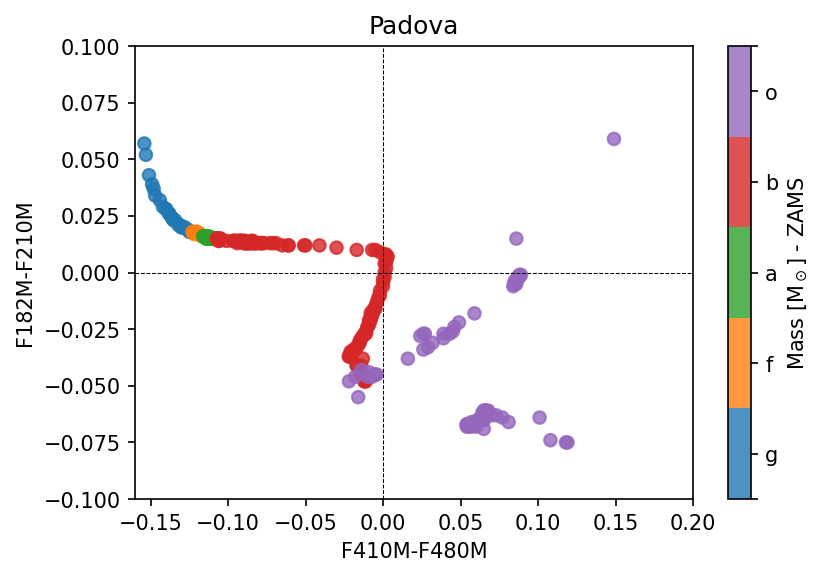

In [24]:
pl.figure(dpi=150)
ax = pl.gca()

massrange = {'o': (16, np.max(padova['Mini'])),
             'b': (2.1, 16),
             'a': (1.4, 2.1),
             'f': (1.04, 1.4),
             'g': (0.8, 1.04),
            }

color = np.zeros_like(padova['Mini'])
for ii, sptype in enumerate('gfabo'):
    thissel = (padova['Mini'] >= massrange[sptype][0]) & (padova['Mini'] < massrange[sptype][1])
    target = ii * (1./len(massrange))
    color[thissel] = target



agesel = (padova['logAge'] == 5) & ((padova['F210Mmag'] + distance_modulus) < 20)
sc = ax.scatter(padova['F410Mmag'][agesel] - padova['F480Mmag'][agesel],
           (padova['F182Mmag']-padova['F210Mmag'])[agesel],
           #c=padova['mini'][agesel],
           #cmap='tab10',
           cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:5]),
           c=color[agesel],
           #norm=simple_norm(color[agesel]),
           alpha=0.8,
          )
cb = pl.colorbar(mappable=sc)
#cb.set_ticks([0.5,1,5,10,50,250])
#cb.set_ticks([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
cb.set_ticks([0.0, 1/5 * 0.8 / 2, 3/10 * 0.8, 5/10 * 0.8, 7/10*0.8, 9/10*0.8, 0.8,])
cb.set_ticklabels(['', 'g', 'f', 'a', 'b', 'o', ''])
cb.set_label("Mass [M$_\odot$] - ZAMS")





pl.axhline(0, linestyle='--', color='k', linewidth=0.5)
pl.axvline(0, linestyle='--', color='k', linewidth=0.5)
pl.xlabel("F410M-F480M")
pl.ylabel("F182M-F210M")
pl.title("Padova")
pl.axis([-0.16,0.2,-0.1,0.1])